In [109]:
!git add *.ipynb
!git commit -m "Next* commit"

In [107]:
!git commit -m "Next* commit"

[master 496dbbf] Next* commit
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite code.ipynb (90%)


In [108]:
!git push -u origin master

Counting objects: 3, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 1.10 KiB | 66.00 KiB/s, done.
Total 3 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/k3larra/explain1.git
   283acfc..496dbbf  master -> master
Branch 'master' set up to track remote branch 'master' from 'origin'.


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [8]:
%cd "/content/drive/My Drive/spisaribb"

/content/drive/My Drive/spisaribb


In [9]:
# Import necessary libraries
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys
sys.path.insert(0, os.path.abspath('code'))
from gradcam import *
from zipfile import ZipFile
from fastai.vision import * 
from fastai.metrics import error_rate
from PIL import Image
import matplotlib.pyplot as plt
# constants
path_img = 'images/data'

In [8]:
# Do initially to extract images from zip
with ZipFile('images/data_2.zip', 'r') as zip: 
    zip.extractall('images')

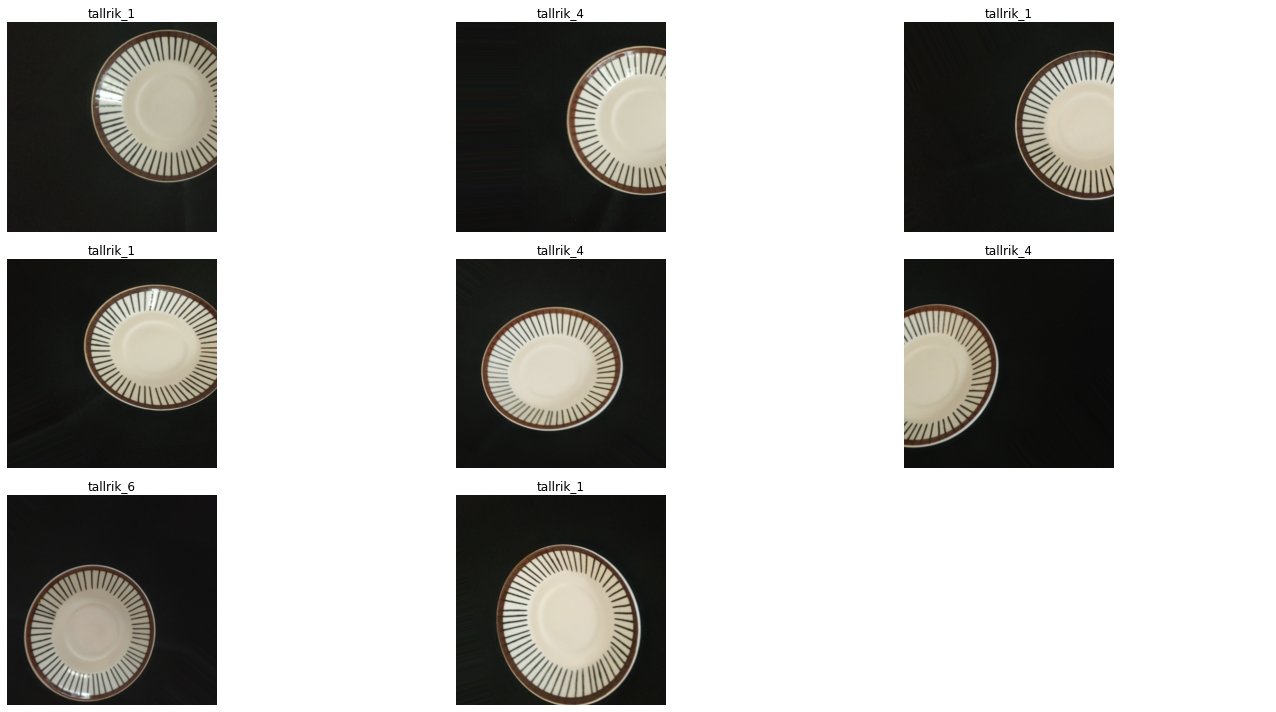

In [11]:
tfms = get_transforms(
    do_flip=False,
    max_rotate=120,
    #max_lighting=0.7,
    #max_warp=0.4
)
data = ImageDataBunch.from_folder(path_img, size=640, bs=8, ds_tfms=tfms, padding_mode="border")
data.normalize();
data.show_batch(rows=4, figsize=(20,10))

epoch,train_loss,valid_loss,error_rate,time
0,2.566081,2.317808,0.635417,01:07
1,2.132837,0.828178,0.375000,00:43
2,1.633689,0.680379,0.250000,00:43
3,1.450814,0.379860,0.145833,00:43


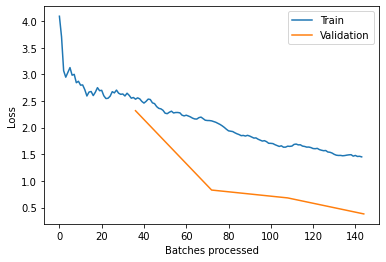

In [14]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)
#learn.fit(64)
learn.fit_one_cycle(4)
learn.recorder.plot_losses() 

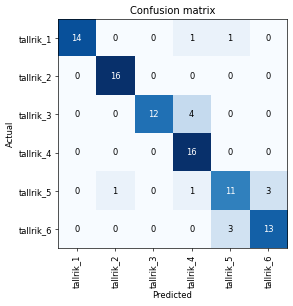

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

## GradCAM explanation

In [16]:
generate_cam(learn, path_img+'/valid/tallrik_1/1586527524387-0006.png', 1)
generate_cam(learn, path_img+'/valid/tallrik_2/1586527650509-0015.png', 2)
generate_cam(learn, path_img+'/valid/tallrik_3/1586527774489-0010.png', 3)
generate_cam(learn, path_img+'/valid/tallrik_4/1586527881568-0003.png', 4)
generate_cam(learn, path_img+'/valid/tallrik_5/1586527988265-0002.png', 5)
generate_cam(learn, path_img+'/valid/tallrik_6/1586528086152-0010.png', 6)

Output hidden; open in https://colab.research.google.com to view.

# Lime


#Shap